In [1]:
"""
Please install the following libraries to run the code
Some libraries may be missing, so please download them if you do encounter an error
"""
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install opencv-python
# !pip install torch
# !pip install torchvision
# !pip install scikit-image
# !pip install git+https://github.com/keras-team/keras-tuner.git
# !pip install autokeras
# !pip install keras
# !pip install tensorboard

'Please install the following libraries to run the code'

# Uploading Dependencies

In [17]:
#importing all necessary libraries
import os
import shutil
import random
import numpy as np
from numpy import asarray
import csv
import matplotlib.pyplot as plt
import math
from datetime import date

import autokeras as ak

import tensorflow as tf

import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from pytorch_lightning.loggers import CSVLogger

import keras
import gc
import cv2

from tensorflow.keras.models import load_model

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)
num_workers = 4 ## Set to your device
torch.cuda.empty_cache()

#check if autokeras uses GPU
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        # Prevent TensorFlow from consuming all memory
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        # In case you re-run the cell
        print(e)

# Set the global policy to mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')


cuda:0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


# Loading Dataset

In [2]:
def add_data (csv_path, images_path, image_array, label_array, id_finish = None):
    """
    add_data function
    this function takes in 
    1.a path to a csv
    2.an image folder path corresponding to the csv
    3.and an image_array and label_array instance
    4.and an id_finish, default None can be set to have control of how many datapoints is to be added during an instance call

    The function opens the csv file as per the given path and lists all datapoints in the csv (i)
    reads the images corresponding to the datapoints and updates the
    image_array and label_array instances passed in as argument

    return: updated populated image_array and label array containing datapoints in the speicfied folder
    """

    if id_finish == None:
        with open(csv_path) as file_obj:
            reader_obj = csv.reader(file_obj) 
            list_arr = list(reader_obj)
            id_finish = len(list_arr)

    with open(csv_path) as file_obj:
        reader_obj = csv.reader(file_obj) 
        idCounter = 0

        #loop through folder x times as specified by the amount of datapoints in the cvs or specified by input     
        for labels in reader_obj: 
            if idCounter < id_finish:
                if not(labels[0] == labels[1] and (labels[0] == '0' or labels[0] == 0)): #remove all zeros 
                    
                    object = np.array([labels]).astype(int)

                    #image augmentation block
                    img_add = cv2.cvtColor(cv2.imread(images_path + "img_" + str(idCounter) +".png"),cv2.COLOR_BGR2RGB)
                    
                    #crop image
                    img_add = [asarray(img_add)[0:320][180:260]]
                    
                    #label and image append
                    label_array.append(object)
                    image_array.append(img_add)
                
            idCounter += 1
    return image_array, label_array #need to be returned since np.append returns a new list 



In [3]:

#image array initialisation
img = asarray(cv2.cvtColor(cv2.imread("datasets/normal_dataset/dataset1/pibot_dataset/img_" + str(0) +".png"),cv2.COLOR_BGR2RGB))
img_arr = [img[0:320][180:260]]#initialise array

#label array intialisation
label_arr = [[0,0]]

#populate the image array and label array for training
img_arr, label_arr = add_data('datasets/dataset_11thMar/clockwise_full_track_slow/pibot_dataset/actions.csv', 'datasets/dataset_11thMar/clockwise_full_track_slow/pibot_dataset/', img_arr, label_arr)
print(len(img_arr), len(label_arr)) #check if funcrtion works fine

for i in range(7):
    img_arr, label_arr = add_data('datasets/dataset_11thMar/turns_only_slow_' + str(i+1) + '/pibot_dataset/actions.csv', 'datasets/dataset_11thMar/turns_only_slow_' + str(i+1) + '/pibot_dataset/', img_arr, label_arr)
print(len(img_arr), len(label_arr)) #check if funcrtion works fine

for i in range(2):
    img_arr, label_arr = add_data('datasets/dataset_11thMar/anti_cw_full_track_slow_' + str(i+1) + '/pibot_dataset/actions.csv', 'datasets/dataset_11thMar/anti_cw_full_track_slow_' + str(i+1) + '/pibot_dataset/', img_arr, label_arr)
print(len(img_arr), len(label_arr)) #check if funcrtion works fine

for i in range(3):
    img_arr, label_arr = add_data('datasets/dataset_25thMar/25032024_turns_' + str(i+1) + '/pibot_dataset/actions.csv', 'datasets/dataset_25thMar/25032024_turns_' + str(i+1) + '/pibot_dataset/', img_arr, label_arr)
print(len(img_arr), len(label_arr)) #check if funcrtion works fine

for i in range(1):
    img_arr, label_arr = add_data('datasets/dataset_25thMar/25032024_unideal_' + str(i+1) + '/pibot_dataset/actions.csv', 'datasets/dataset_25thMar/25032024_unideal_' + str(i+1) + '/pibot_dataset/', img_arr, label_arr)
print(len(img_arr), len(label_arr)) #check if funcrtion works fine

"""FOR FINE TUNING, fine tune the model with 22nd April Dataset"""
# for i in range(1):
#     img_arr, label_arr = add_data('datasets/dataset_22ndApr/220424_180_turns_' + str(i+1) + '/pibot_dataset/actions.csv', 'datasets/dataset_22ndApr/220424_180_turns_' + str(i+1) + '/pibot_dataset/', img_arr, label_arr)
# print(len(img_arr), len(label_arr)) #check if funcrtion works fine



1546 1546
3496 3496
5018 5018
6245 6245
6891 6891


'FOR FINE TUNING, fine tune the model with 22nd April Dataset'

# Data Pre-Processing

(6890, 60, 320, 3)


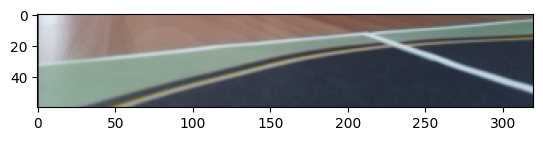

In [4]:
#visualise a sample datapoint 
label_arr = np.array(label_arr[1:len(label_arr)])
label_arr = label_arr.reshape(label_arr.shape[0], label_arr.shape[2])

img_arr = np.array(img_arr[1:len(img_arr)])
img_arr = img_arr.reshape(img_arr.shape[0], img_arr.shape[2], img_arr.shape[3], img_arr.shape[4])

plt.imshow(img_arr[0])
print(img_arr.shape)


In [5]:
#get estimate of datapoints as a metric for balancing amount of data to use during training
straights = 0
right_turns = 0
left_turns = 0

straight_images = []
straight_label = []

right_images = []
right_label = []

left_images = []
left_label = []

for i in range(len(label_arr)):
    left, right = label_arr[i]
    if np.abs(left-right) < 3: #this value can be tuned as to what is perceived as correct
        straights += 1
        straight_images.append(img_arr[i])
        straight_label.append(label_arr[i])

    elif (left-right) > 0:
        right_turns += 1
        right_images.append(img_arr[i])
        right_label.append(label_arr[i])

    else:
        left_turns += 1
        left_images.append(img_arr[i])
        left_label.append(label_arr[i])


straight_images = np.array(straight_images)
straight_label = np.array(straight_label)

right_images = np.array(right_images)
right_label = np.array(right_label)

left_images = np.array(left_images)
left_label = np.array(left_label)

print("estimate straight data: ", straights)
print("estimate right turns data: ", right_turns)
print("estimate left turns data: ", left_turns)

estimate straight data:  2529
estimate right turns data:  1960
estimate left turns data:  2401


# Get Normalisation Values

In [6]:
"""
Robust Normalisation
To normalise the dataset labels, the robust normalisation was used with the intention so that
the model can cope better with outliers which can be quite frequently seen in our dataset

"""

mean_label = np.mean(label_arr)
std_label = np.std(label_arr)

sorted_label = np.sort(label_arr.reshape(-1))
median_label = np.median(sorted_label)
Q1,Q3 = np.percentile(sorted_label,[25,75])
IQR_label = Q3-Q1

print("IQR value of the labels is: ", IQR_label)
print("The median of the labels is: ", median_label)

IQR value of the labels is:  26.0
The median of the labels is:  12.0


In [7]:

ch_sum = np.zeros(3)
ch_sum_sq = np.zeros(3)

num_pixels = 0

for images in img_arr:
    images = images/255.0
    images = images.reshape(3,-1)
    ch_sum += np.sum(images,axis = 1)
    ch_sum_sq += np.sum(np.square(images), axis = 1)
    
    num_pixels += images.shape[1]

mean_dataset = ch_sum/num_pixels
std_dataset = np.sqrt((ch_sum_sq / num_pixels) - np.square(mean_dataset))

print("the mean of the channels of the images are [R, G, B] : ", mean_dataset)
print("the std of the channels of the images are [R, G, B] : ",std_dataset)

the mean of the channels of the images are [R, G, B] :  [0.53119481 0.49549976 0.44532117]
the std of the channels of the images are [R, G, B] :  [0.20993134 0.2067396  0.20073124]


# Data Preparation For Training

In [12]:
transform_tensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean= mean_dataset,std= std_dataset),])

In [8]:
class Section1Data(Dataset):
    def __init__(self, img_input, label_input, index = None,transform=None):
        # Load numpy data
        # Create dataset for trainloader --> images arr_0, labels arr_1
        self.transform = transform   ## Save the transforms as your class' attributes
        
        if index != None:
            
            if self.transform != None:
                self.images = [img_input[i] for i in index]
                for i in range(len(self.images)):
                    current_img = self.transform(self.images[i]).numpy()
            
                    self.images[i] = current_img
                    
            else:
                self.images = [img_input[i] for i in index]
                
            self.labels = [label_input[i] for i in index]
        
        else: 
            if self.transform != None:
        
                index = range(len(img_input))
                self.images = [img_input[i] for i in index]
                
                
                for i in range(len(self.images)):
                    self.images[i] = self.transform(self.images[i]).numpy()


                self.labels = [label_input[i] for i in index]
            else:
                self.images = [img_input]
                self.labels = [label_input]
        
        #robust normalisation
        self.labels = np.asarray(self.labels).astype('float32') - median_label
        self.labels = self.labels/IQR_label
    
    # Define len function
    def __len__(self):
        return len(self.labels)

    # Define getitem function
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx]
        labels = self.labels[idx]

        return sample, labels

In [9]:
import random
"""
get indexes for division
train, val, test --> 60 30 10
"""
def get_id(passed_arr):
  total = len(passed_arr)
  num_train = int(np.floor(0.6*total))
  num_val = int(np.floor(0.3*total))

  id_list = list(range(total))
  train_id = random.sample(id_list,num_train )

  for index in sorted(train_id, reverse=True):
    id_list.pop(index)

  id_list2 = list(range(len(id_list))) #after the removal, the id list len will change
  val_pseudo_id = random.sample(id_list2, num_val)
  val_id = [id_list[i] for i in val_pseudo_id]

  for index in sorted(val_pseudo_id, reverse=True):
    id_list.pop(index)

  test_id = id_list #whatever is left
  
  return train_id,val_id,test_id

Load Data into Dataloader

In [13]:
straight_train, straight_val, straight_test = get_id(straight_label)
right_train, right_val, right_test = get_id(right_label)
left_train, left_val, left_test = get_id(left_label)

def combine(images_array1, images_array2, images_array3, label_array1, label_array2, label_array3, id1, id2, id3):

    combined_images = images_array1[id1]
    combined_images = np.append(combined_images, images_array2[id2], axis = 0)
    combined_images = np.append(combined_images, images_array3[id3], axis = 0)

    combined_labels = label_array1[id1]
    combined_labels = np.append(combined_labels, label_array2[id2], axis = 0)
    combined_labels = np.append(combined_labels, label_array3[id3], axis = 0)

    return combined_images, combined_labels

train_images, train_labels = combine(straight_images, right_images, left_images, straight_label, right_label, left_label, straight_train, right_train, left_train)
print(train_images.shape)
print(train_labels.shape)

val_images, val_labels = combine(straight_images, right_images, left_images, straight_label, right_label, left_label, straight_val, right_val, left_val)
print(val_images.shape)
print(val_labels.shape)

test_images, test_labels = combine(straight_images, right_images, left_images, straight_label, right_label, left_label, straight_test, right_test, left_test)
print(test_images.shape)
print(val_labels.shape)


#now shuffle the trainset first
temp = list(zip(train_images, train_labels))
random.shuffle(temp)
res1, res2 = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
train_images, train_labels = np.array(res1), np.array(res2)

(4133, 60, 320, 3)
(4133, 2)
(2066, 60, 320, 3)
(2066, 2)
(691, 60, 320, 3)
(2066, 2)


In [14]:
BATCH_SIZE = 16

trainset = Section1Data(train_images, train_labels, transform = transform_tensor)
valset = Section1Data(val_images, val_labels, transform = transform_tensor)
testset = Section1Data(test_images, test_labels, transform = transform_tensor)

testloader  = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 0)

# Training Setup

In [16]:
tf.keras.backend.clear_session()  # Clear the session to free memory

gc.collect()
tf.get_logger().setLevel('INFO')

In [29]:
run = 9
save_name="image_regressor_" + str(date.today()) + "_run" + str(run)
max_epochs = 60
regressor = ak.ImageRegressor(
    overwrite=True, 
    project_name= save_name, 
    max_trials=1, 
    metrics = ['mse'], 
    loss = 'mse',
    max_model_size = 24000000
    )

log_save = "logs_" + save_name

tensorboard_callback_train = tf.keras.callbacks.TensorBoard(
    log_dir= log_save ,
    update_freq="epoch"
    )

history = regressor.fit(
    x=np.array(trainset.images), 
    y = np.array(trainset.labels), 
    epochs = max_epochs, 
    callbacks=[tensorboard_callback_train], 
    verbose = 1, 
    validation_data=(np.array(valset.images), np.array(valset.labels)),
    batch_size = 64
    )

Trial 1 Complete [00h 01m 01s]
val_loss: 0.5732633471488953

Best val_loss So Far: 0.5732633471488953
Total elapsed time: 00h 01m 01s
Epoch 1/60
65/65 [==============================] - 9s 71ms/step - loss: 13.3279 - mse: 13.3279 - val_loss: 0.6209 - val_mse: 0.6209
Epoch 2/60
65/65 [==============================] - 3s 49ms/step - loss: 2.7674 - mse: 2.7674 - val_loss: 0.6250 - val_mse: 0.6250
Epoch 3/60
65/65 [==============================] - 3s 50ms/step - loss: 2.6333 - mse: 2.6333 - val_loss: 0.7100 - val_mse: 0.7100
Epoch 4/60
65/65 [==============================] - 3s 49ms/step - loss: 2.7313 - mse: 2.7313 - val_loss: 0.6019 - val_mse: 0.6019
Epoch 5/60
65/65 [==============================] - 3s 50ms/step - loss: 2.1380 - mse: 2.1380 - val_loss: 1.8224 - val_mse: 1.8224
Epoch 6/60
65/65 [==============================] - 3s 49ms/step - loss: 2.2322 - mse: 2.2322 - val_loss: 0.5798 - val_mse: 0.5798
Epoch 7/60
65/65 [==============================] - 3s 49ms/step - loss: 2.186

INFO:tensorflow:Assets written to: .\image_regressor_2024-05-14_run9\best_model\assets


INFO:tensorflow:Assets written to: .\image_regressor_2024-05-14_run9\best_model\assets


In [39]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

## VIEWING TRAIN LOSS AND VAL LOSS

In [16]:
"""
To View the logs, you can use tensorboard or run the next few cells (the next few cell only works right after training, 
the notebook is restarted, please view it with tensorboard with the steps written below).

steps:
1. Identify the logs directory
2. Open Command prompt
3. Ensure the current environment is the correct one with tensorboard installed
4. if tensorboard non installed, run "pip3 install tensorboard"
5. run the following:
    tensorboard.exe --logdir "path to logs"

    MAKE SURE path to logs is the full path just to ensure it is the correct path

6. Once successful, go to a browser and open http://localhost:6006/

7.You can check which val is the lowest by ticking the val_losses. The lowest one would be the best model saved by the run
"""

'\nTo View the logs, you can use tensorboard or run the next few cells (the next few cell only works right after training, \nthe notebook is restarted, please view it with tensorboard with the steps written below).\n\nsteps:\n1. Identify the logs directory\n2. Open Command prompt\n3. Ensure the current environment is the correct one with tensorboard installed\n4. if tensorboard non installed, run "pip3 install tensorboard"\n5. run the following:\n    tensorboard.exe --logdir "path to logs"\n\n    MAKE SURE path to logs is the full path just to ensure it is the correct path\n\n6. Once successful, go to a browser and open http://localhost:6006/\n\n7.You can check which val is the lowest by ticking the val_losses. The lowest one would be the best model saved by the run\n'

# After Training Visualisation

Evaluate model

In [35]:
regressor.evaluate(x=np.array(testset.images), y = np.array(testset.labels))

33/33 [==============================] - 2s 17ms/step - loss: 0.6153 - mse: 0.6153


[0.6152545213699341, 0.6152545213699341]

Visualise Loss

NOTE: This cell will only plot the training loss, TO VIEW THE val loss. Please refer to the tensorboard cell on viewing complete data per epochs

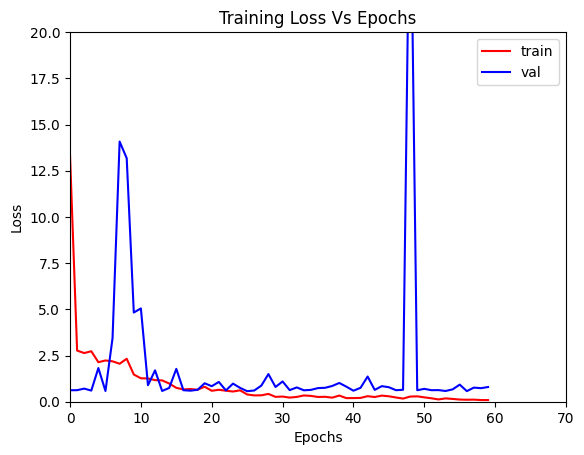

In [31]:
fig,ax = plt.subplots(1)
loss = history.history["loss"]
val = history.history['val_mse']

ax.plot(range(len(loss)), loss, color = 'red')
ax.plot(range(len(val)), val, color = 'blue')
ax.set_xlim([0,70])
ax.set_ylim([0,20])
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training Loss Vs Epochs")
ax.legend(["train", "val"])

Visualise Distribution of Trained Model

Text(0.5, 1.0, 'right wheel distribution')

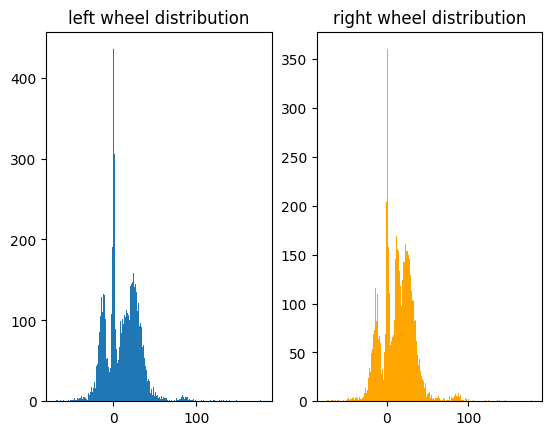

In [17]:
label_left, label_right = label_arr[:,0], label_arr[:,1] 
fig, dataset_distribution = plt.subplots(1,2)
dataset_distribution[0].hist(label_left, bins=np.arange(min(label_left), max(label_left) + 1))
dataset_distribution[1].hist(label_right, bins=np.arange(min(label_right), max(label_right) + 1), color = 'orange')

dataset_distribution[0].set_title("left wheel distribution")
dataset_distribution[1].set_title("right wheel distribution")

Getting predictions

Note: The following cells divides the predictions into smaller batches as passing through the whole daatset into the model may lead to memory issue (OOM)

**Copy, paste, and modify the following cells to ensure it is compatible with your device

In [17]:
train_len = len(trainset.images)
preds_all_train = regressor.predict(np.array(trainset.images[:int(train_len/2)]))
left_pred_train, right_pred_train = preds_all_train[:,0], preds_all_train[:,1]

76/76 [==============================] - 5s 53ms/step


In [18]:
preds_all_train = regressor.predict(np.array(trainset.images[int(train_len/2):]))
left_pred_train2, right_pred_train2 = preds_all_train[:,0], preds_all_train[:,1]

76/76 [==============================] - 4s 50ms/step


In [20]:
val_len = len(valset.images)
preds_all_val = regressor.predict(np.array(valset.images[:int(val_len/2)]))
left_pred_val, right_pred_val = preds_all_val[:,0], preds_all_val[:,1]

17/17 [==============================] - 1s 73ms/step


In [21]:
preds_all_val = regressor.predict(np.array(valset.images[int(val_len/2):]))
left_pred_val2, right_pred_val2 = preds_all_val[:,0], preds_all_val[:,1]

17/17 [==============================] - 1s 65ms/step


In [22]:
test_len = len(testset.images)
preds_all_test = regressor.predict(np.array(testset.images[:int(test_len/2)]))
left_pred_test, right_pred_test = preds_all_test[:,0], preds_all_test[:,1]

17/17 [==============================] - 1s 67ms/step


In [23]:
preds_all_test = regressor.predict(np.array(testset.images[int(test_len/2):]))
left_pred_test2, right_pred_test2 = preds_all_test[:,0], preds_all_test[:,1]

17/17 [==============================] - 1s 53ms/step


In [24]:
left_combined = left_pred_test
left_combined = np.append(left_combined, left_pred_test2)
left_combined = np.append(left_combined, left_pred_val)
left_combined = np.append(left_combined, left_pred_val2)
left_combined = np.append(left_combined, left_pred_train)
left_combined = np.append(left_combined, left_pred_train2)

right_combined = right_pred_test
right_combined = np.append(right_combined, right_pred_test2)
right_combined = np.append(right_combined, right_pred_val)
right_combined = np.append(right_combined, right_pred_val2)
right_combined = np.append(right_combined, right_pred_train)
right_combined = np.append(right_combined, right_pred_train2)


In [25]:

label_left_pred = left_combined*IQR_label+median_label
label_right_pred = right_combined*IQR_label+median_label


In [27]:
print(len(label_left_pred))

6890


In [ ]:
fig, prediction_distribution = plt.subplots(1,2)
prediction_distribution[0].hist(label_left_pred, bins=np.arange(min(label_left_pred), max(label_left_pred) + 1))
prediction_distribution[1].hist(label_right_pred, bins=np.arange(min(label_right_pred), max(label_right_pred) + 1), color = 'orange')

prediction_distribution[0].set_title("left wheel predictions")
prediction_distribution[1].set_title("right wheel predictions")

# Model Visual Evaluation

In [16]:
denormalise = transforms.Compose([ 
                transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1 / s for s in std_dataset ]), 
                transforms.Normalize(mean = [ -m for m in mean_dataset ], std = [ 1., 1., 1. ]),
                ])


In [49]:
def visualiser(iter_item, model, denormalisation):
    """
    visualiser function

    this function takes in an iter() instance of a "Dataloader", model instance, and denormalisation composition

    function will plot 16 plots.

    **TO CHANGE the number of plots, please modify the batch size of the passed iter item and modify the function as needed

    """
    pictures, labels = next(iter_item)

    labels = labels.numpy()
    labels = (labels*IQR_label)+median_label

    pictures = pictures.reshape(BATCH_SIZE,3,60,320) #reshape the picture """TO MODIFY if Batch Size Changed"""
    predictions = model.predict(np.array(pictures))
    predictions = (predictions*IQR_label) + median_label

    fig,comparator = plt.subplots(4,4,figsize = ( 20 , 10 )) #for the subplots

    for i in range(0, 4): #"""TO MODIFY if Batch Size Changed"""
        for j in range(0, 4): #"""TO MODIFY if Batch Size Changed"""
            image = pictures[i*4 + j] #"""TO MODIFY if Batch Size Changed"""
        
            image = denormalisation(image).numpy().transpose((1, 2, 0))
        
            pred = predictions[i*4 + j] #"""TO MODIFY if Batch Size Changed"""
            
            comparator[i][j].imshow(image)
            

            comparator[i][j].set_title("actual left and right wheel \nencoder values:\n" + "L:" + str(labels[i*4 + j][0]) + " R:" + str(labels[i*4 + j][1]) + 
                                        "\npredicted as: \n" + "L:" + str(pred[0]) + " R:" + str(pred[1]))
    plt.tight_layout()

In [47]:
actual_set = iter(testloader)

1/1 [==============================] - 0s 47ms/step


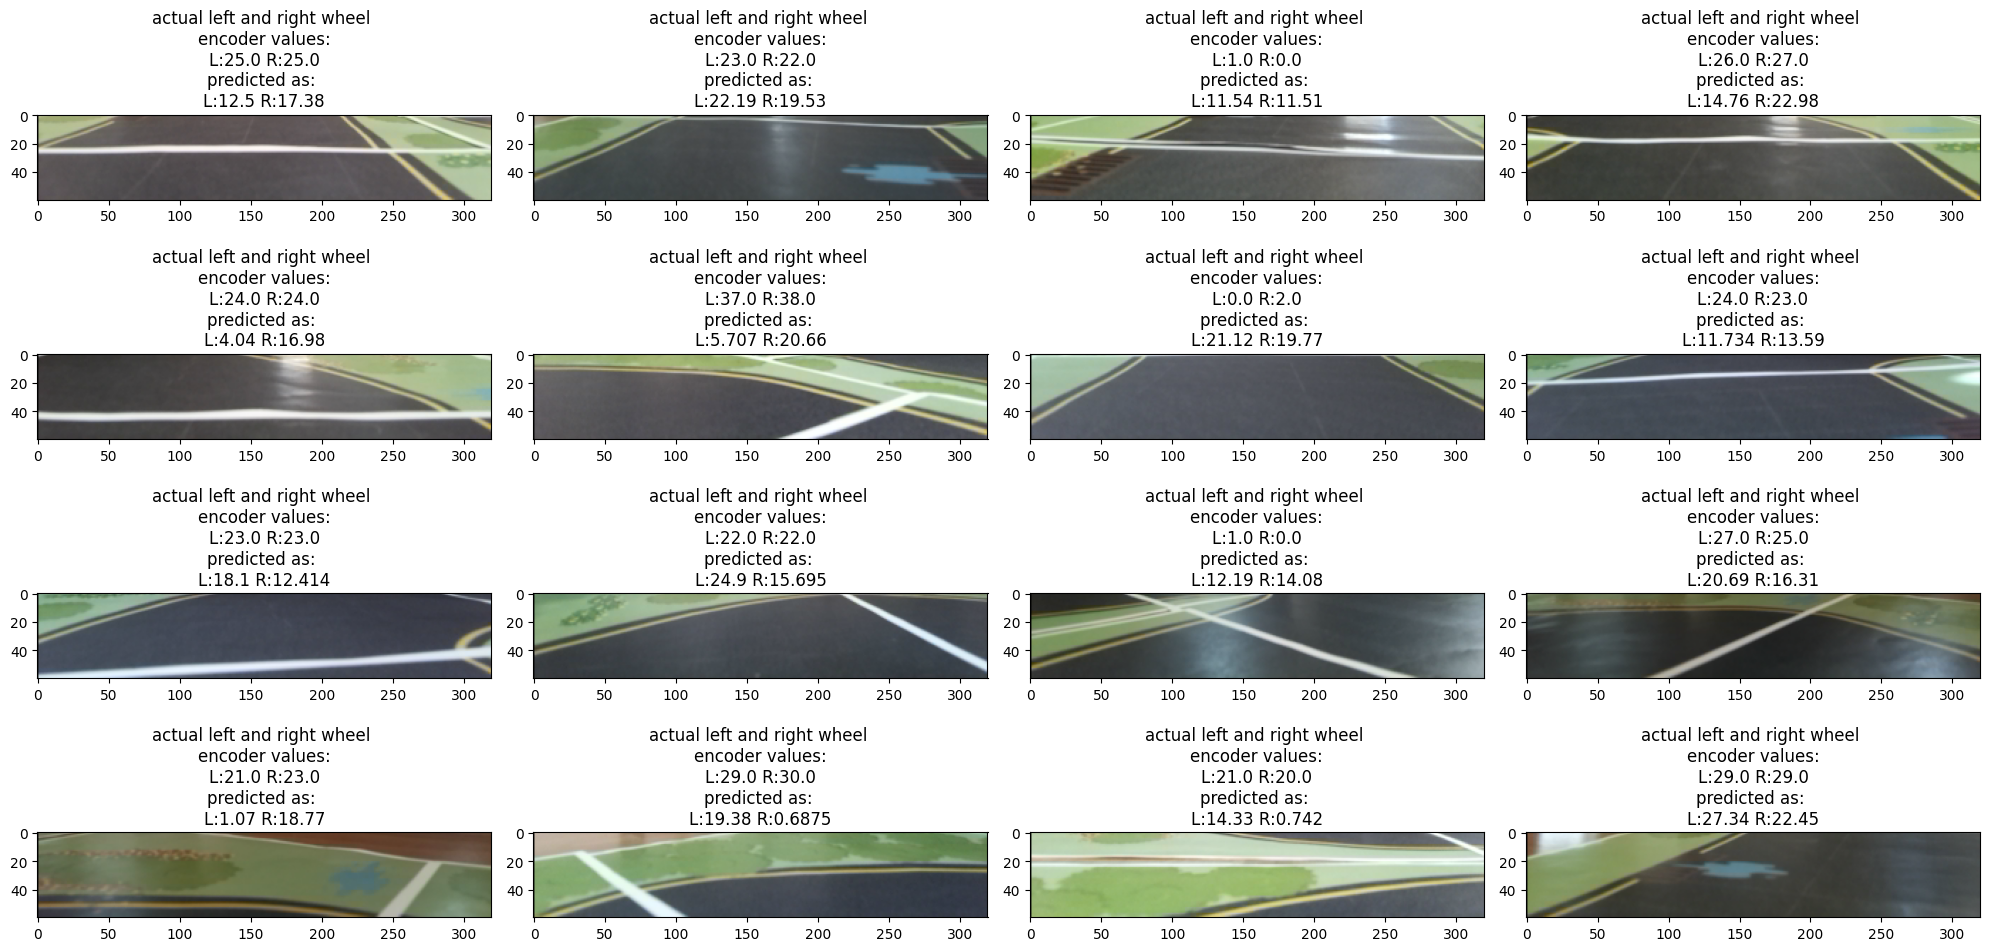

In [50]:
visualiser(actual_set, regressor, denormalise)

1/1 [==============================] - 0s 33ms/step


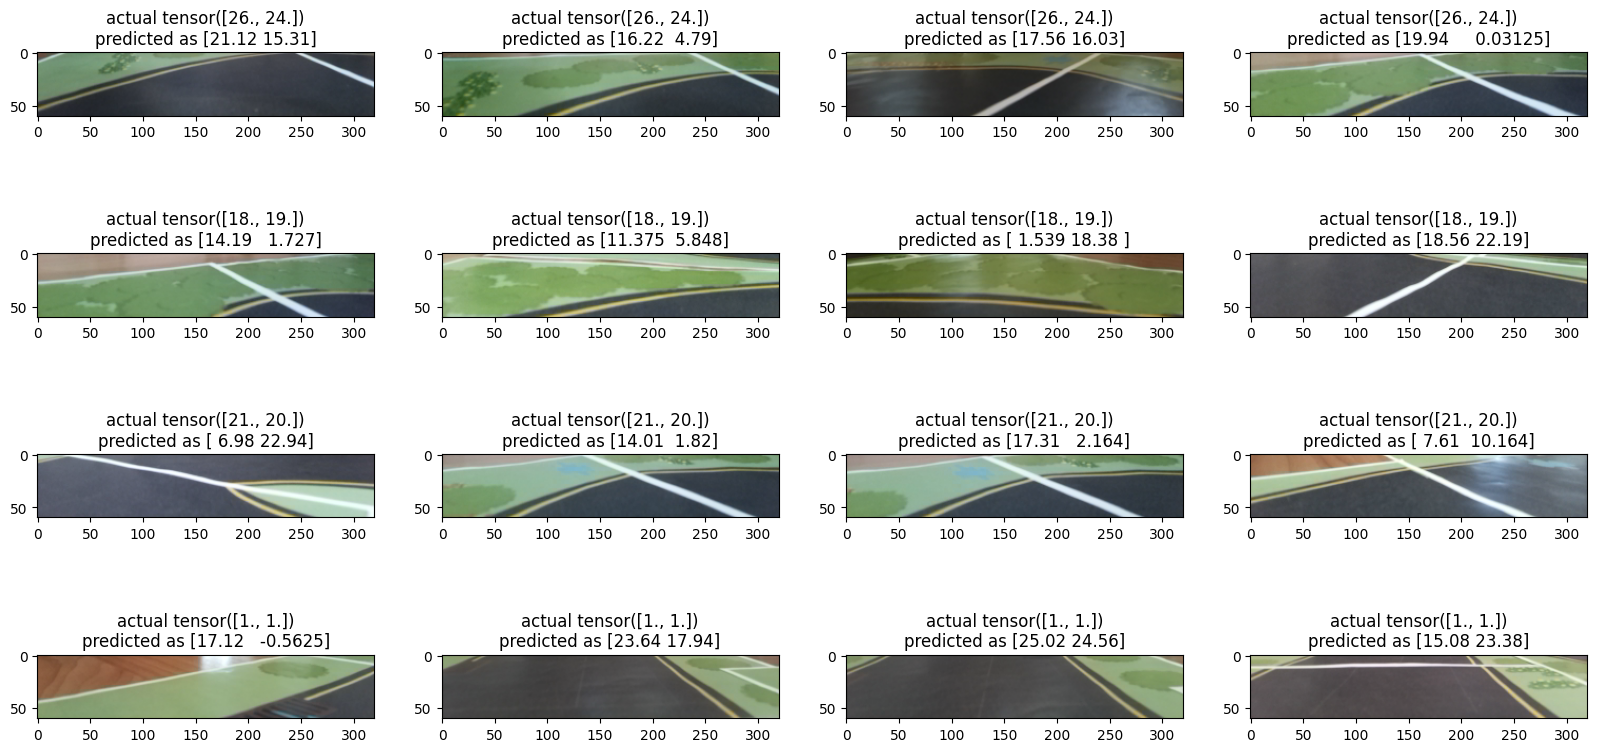

In [89]:
visualiser(actual_set, regressor, denormalise)

1/1 [==============================] - 0s 37ms/step


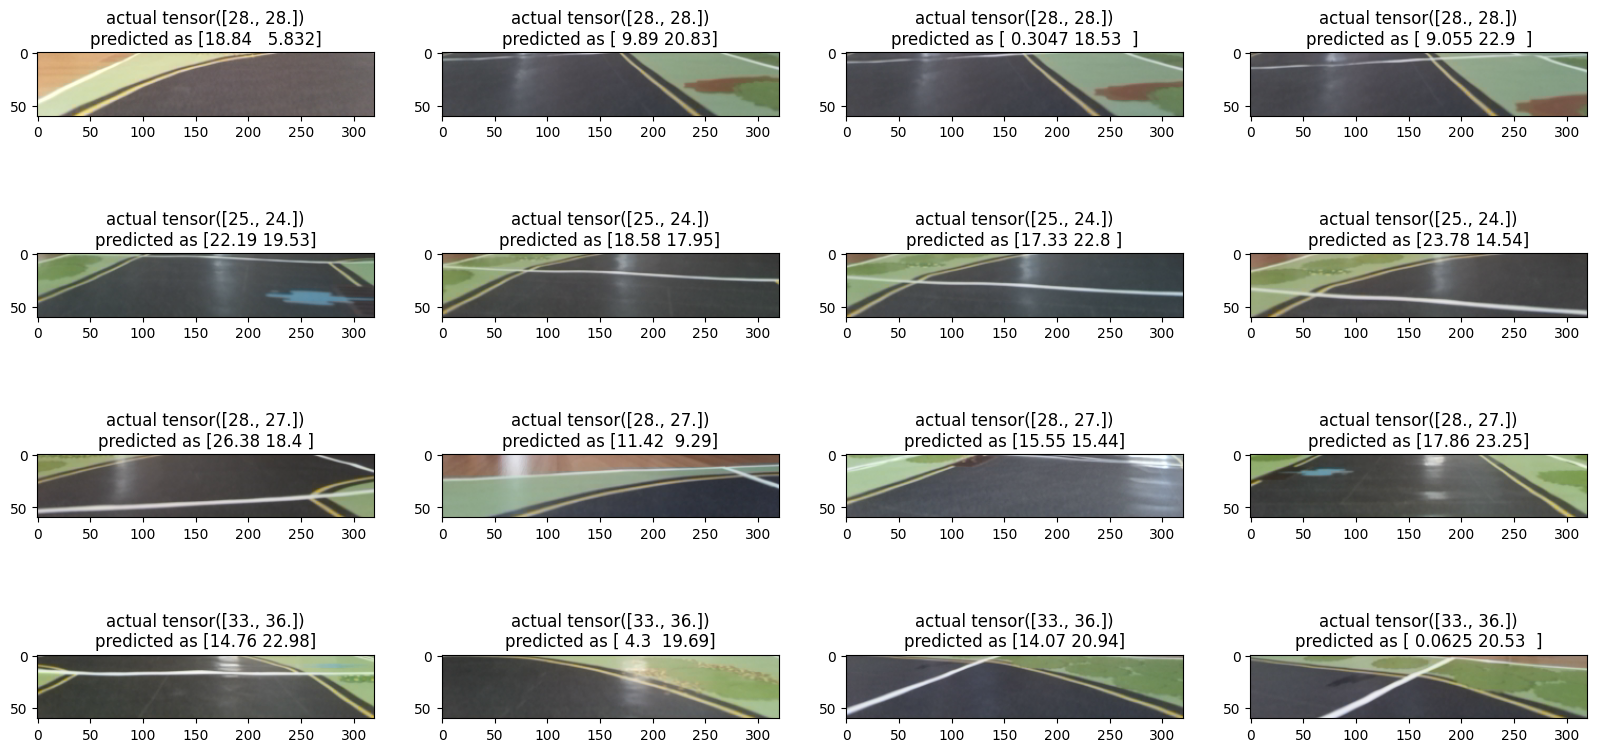

In [90]:
visualiser(actual_set, regressor, denormalise)

In [91]:
#image array initialisation
img = asarray(cv2.cvtColor(cv2.imread("datasets/normal_dataset/dataset1/pibot_dataset/img_" + str(0) +".png"),cv2.COLOR_BGR2RGB))
img_arr_straights = [img[0:320][180:260]]#initialise array

#label array intialisation
label_arr_straights = [[0,0]]

img_arr_straights, label_arr_straights = add_data("datasets/normal_dataset/actions1_Copy.csv", "datasets/normal_dataset/dataset1/pibot_dataset/", img_arr_straights, label_arr_straights)

img_arr_straights = np.array(img_arr_straights[1:len(img_arr_straights)])
img_arr_straights = img_arr_straights.reshape(img_arr_straights.shape[0], img_arr_straights.shape[2], img_arr_straights.shape[3], img_arr_straights.shape[4])

label_arr_straights = np.array(label_arr_straights[1:len(label_arr_straights)])
label_arr_straights = label_arr_straights.reshape(label_arr_straights.shape[0], label_arr_straights.shape[2])

# Call training dataset and create the trainloader. Make sure to transform your data to tensor!!!! Shuffle your training data
test_straights = Section1Data(img_arr_straights, label_arr_straights, transform = transform_tensor)  
test_straights  = DataLoader(dataset=test_straights, batch_size=16, shuffle=False, num_workers = 0)

straights_iter = iter(test_straights)

1/1 [==============================] - 0s 31ms/step


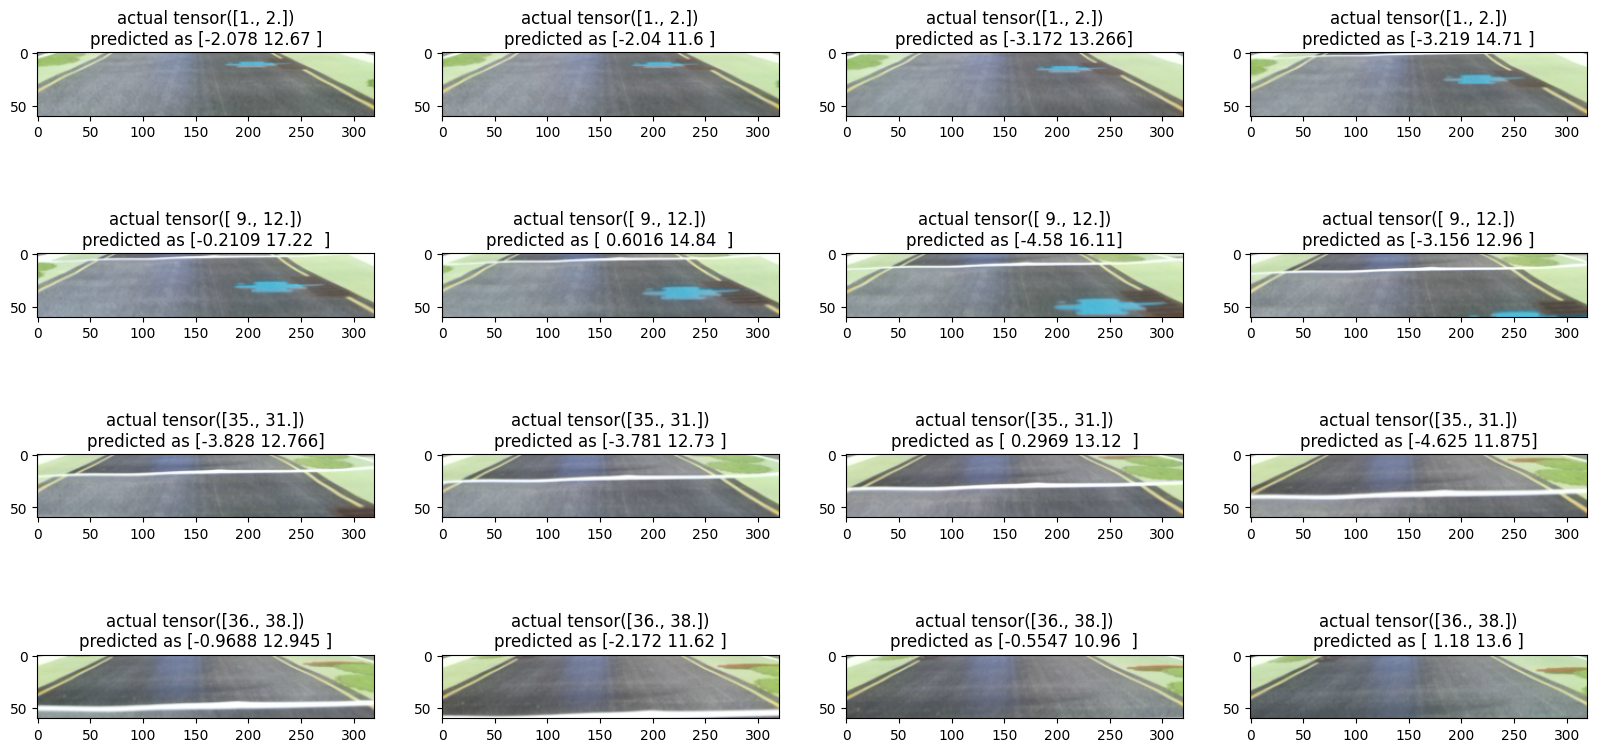

In [92]:
visualiser(straights_iter, regressor, denormalise)

1/1 [==============================] - 0s 32ms/step


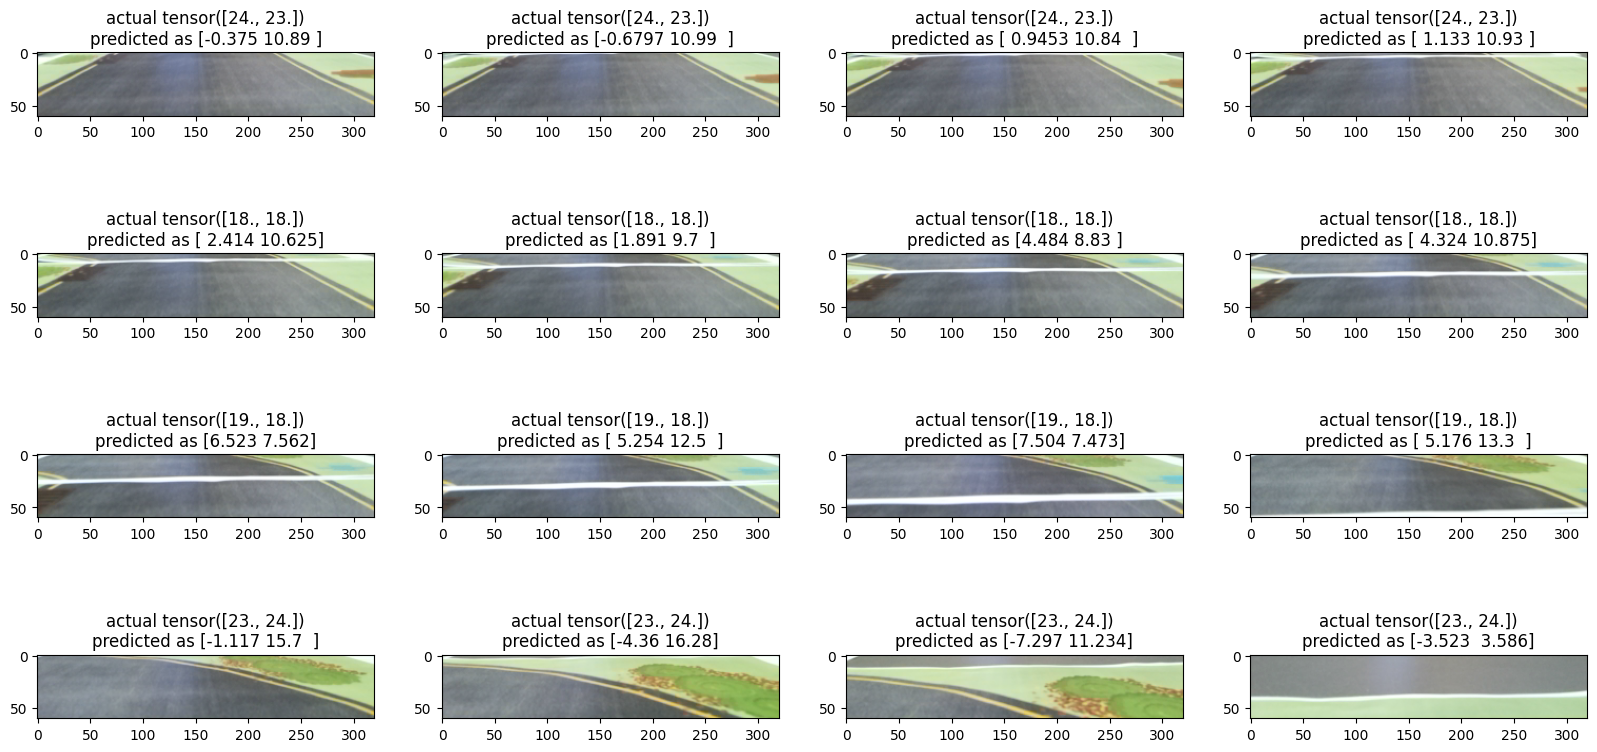

In [93]:
visualiser(straights_iter, regressor, denormalise)

# Final Step: Saving Model

In [94]:
model_to_save = regressor.export_model()
model_name = "model_autokeras_" + str(date.today()) + "_" + str(max_epochs) + "Epochs" + "_run" + str(run)
model_to_save.save(model_name, save_format="tf")
model_to_save.summary()

INFO:tensorflow:Assets written to: model_autokeras_2024-05-12_55Epochs_run3\assets


INFO:tensorflow:Assets written to: model_autokeras_2024-05-12_55Epochs_run3\assets


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 60, 320)]      0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 3, 60, 320)       0         
 t32)                                                            
                                                                 
 resizing (Resizing)         (None, 224, 224, 320)     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       963       
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                             

Getting model summary and moving all the model files to a single folder

In [95]:

summary_file = "modelsummary.txt"
with open('modelsummary.txt', 'w') as f:
    model_to_save.summary(print_fn=lambda x: f.write(x + '\n'))

In [96]:
path = "C:/Users/david/Downloads/IL_TRAINING/"
new_folder = str(date.today()) + "_model/"

os.mkdir(path+new_folder)

shutil.move(path+model_name, path+new_folder+model_name) #move model into folder
shutil.move(path+save_name, path+new_folder+save_name) #save image regressor file into folder
shutil.move(path+summary_file, path+new_folder+summary_file) #move model summary into folder
shutil.move(path+log_save, path+new_folder+log_save) #move model log into folder

run += 1

# FINE TUNING SECTION

Please run the following functiosn in the previous sections before fine-tuning

1.Dependencies Import 

2.Add_data function 

3.Section1Data Class

# load model that needs fine tuning

In [15]:

path = "C:/Users/david/Downloads/IL_TRAINING/2024-05-12_model/"
model_name = "model_autokeras_2024-05-12_55Epochs_run3"
model_to_finetune= load_model(path+model_name, custom_objects=ak.CUSTOM_OBJECTS) #make sure this model autokeras folder is in the same dir as this ipynb file
model_to_finetune.summary()
#model_to_finetune.evaluate(x=np.array(testset.images), y = np.array(testset.labels))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU, compute capability 8.6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 60, 320)]      0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 3, 60, 320)       0         
 t32)                                                            
                                                                 
 resizing (Resizing)         (None, 224, 224, 320)     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       963       
                                                                 
 res

In [16]:
regressor = model_to_finetune

# LOAD NEW DATA

In [6]:
#image array initialisation
img = asarray(cv2.cvtColor(cv2.imread("datasets/normal_dataset/dataset1/pibot_dataset/img_" + str(0) +".png"),cv2.COLOR_BGR2RGB))
new_img_arr = [img[0:320][180:260]]#initialise array

#label array intialisation
new_label_arr = [[0,0]]

#populate the image array and label array for fine tuning
"""FOR FINE TUNING, fine tune the model with 22nd April Dataset"""
for i in range(1):
    new_img_arr, new_label_arr = add_data('datasets/dataset_22ndApr/220424_180_turns_' + str(i+1) + '/pibot_dataset/actions.csv', 'datasets/dataset_22ndApr/220424_180_turns_' + str(i+1) + '/pibot_dataset/', new_img_arr, new_label_arr)
print(len(new_img_arr), len(new_label_arr)) #check if funcrtion works fine


829 829


(828, 60, 320, 3)


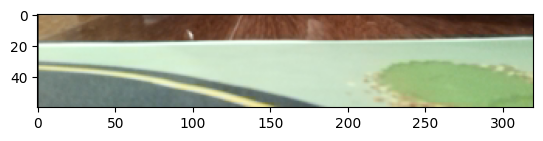

In [7]:
new_label_arr = new_label_arr[1:len(new_label_arr)]
new_img_arr = new_img_arr[1:len(new_img_arr)]

plt.imshow(new_img_arr[0])
print(new_img_arr.shape)

In [8]:
"""
FINE TUNING IQR and Median
during fine tuning, the IQR and median is still needed to normalise the finetuned dataset
assume same distribution and normalise the new dataset with the IQR and median values of the 
model that is subjected to fine tuning
"""
IQR_label = 26
median_label = 12
mean_dataset = [0.53119481, 0.49549976, 0.44532117]
std_dataset = [0.20993134, 0.2067396,  0.20073124]

In [9]:
fine_tune_transform_tensor = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean= mean_dataset,std= std_dataset),])

In [10]:
"""
get indexes for division
train, val, test --> (70 15) 15
"""
total_new = len(new_img_arr)
id_list = list(range(total_new))
train_id_new = random.sample(id_list, math.floor(0.85*total_new))

for index in sorted(train_id_new, reverse=True):
  id_list.pop(index)
    
test_id_new = id_list #whatever is left

In [11]:
BATCH_SIZE = 16


# Call training dataset and create the trainloader. Make sure to transform your data to tensor!!!! Shuffle your training data
fine_trainset = Section1Data(new_img_arr, new_label_arr, index = train_id_new, transform = fine_tune_transform_tensor)  

# Call testing dataset and create the testloader. Make sure to transform your data to tensor!!!!
fine_testset = Section1Data(new_img_arr, new_label_arr, index = test_id_new, transform = fine_tune_transform_tensor) 
fine_testloader  = DataLoader(dataset=fine_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 0)

In [ ]:
#setting up the model for fine tuning
#setting trainable to false and putting a new overhead input and output layers
model_to_finetune.trainable = False
new_in_layer = keras.Input(shape = (3,60,320))
x = model_to_finetune(new_in_layer, training = False)
outputs = keras.layers.Dense(2)(x)

New_model_architecture = keras.Model(new_in_layer, outputs)
New_model_architecture.summary(show_trainable=True)


fitting top layer of model i.e putting trainable as false so it will only train the new input and output layers added in the previous cell

In [14]:
New_model_architecture.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()],
)

top_fit = model_name + "_top_fitted"
log_top_fit = "logs_" + top_fit
tensorboard_callback_fine_top = tf.keras.callbacks.TensorBoard(
    log_dir= log_top_fit ,
    update_freq="epoch"
    )


print("Fitting the top layer of the model")
New_model_architecture.fit(x=np.array(fine_trainset.images), 
                           y = np.array(fine_trainset.labels), 
                           epochs=50, #modify as per needed
                           callbacks=[tensorboard_callback_fine_top]
                           )

Fitting the top layer of the model


Epoch 1/50
22/22 [==============================] - 3s 17ms/step - loss: 1.1677 - mean_squared_error: 1.1675
Epoch 2/50
22/22 [==============================] - 0s 9ms/step - loss: 1.1396 - mean_squared_error: 1.1397
Epoch 3/50
22/22 [==============================] - 0s 9ms/step - loss: 1.1142 - mean_squared_error: 1.1143
Epoch 4/50
22/22 [==============================] - 0s 7ms/step - loss: 1.0902 - mean_squared_error: 1.0901
Epoch 5/50
22/22 [==============================] - 0s 7ms/step - loss: 1.0677 - mean_squared_error: 1.0677
Epoch 6/50
22/22 [==============================] - 0s 6ms/step - loss: 1.0469 - mean_squared_error: 1.0468
Epoch 7/50
22/22 [==============================] - 0s 7ms/step - loss: 1.0265 - mean_squared_error: 1.0265
Epoch 8/50
22/22 [==============================] - 0s 7ms/step - loss: 1.0082 - mean_squared_error: 1.0082
Epoch 9/50
22/22 [==============================] - 0s 7ms/step - loss: 0.9906 - mean_squared_error: 0.9907
Epoch 10/50
22/22 [========

In [15]:
tf.keras.backend.clear_session()  # Clear the session to free memory

Load Complete Dataset for End-End Fitting

In [16]:
#image array initialisation
img = asarray(cv2.cvtColor(cv2.imread("datasets/normal_dataset/dataset1/pibot_dataset/img_" + str(0) +".png"),cv2.COLOR_BGR2RGB))
complete_img_arr = [img[0:320][180:260]]#initialise array

#label array intialisation
complete_label_arr = [[0,0]]

#populate the image array and label array for training
complete_img_arr, complete_label_arr = add_data('datasets/dataset_11thMar/clockwise_full_track_slow/pibot_dataset/actions.csv', 
                                                'datasets/dataset_11thMar/clockwise_full_track_slow/pibot_dataset/', 
                                                complete_img_arr, complete_label_arr)

print(len(complete_img_arr), len(complete_label_arr)) #check if funcrtion works fine

for i in range(7):
    complete_img_arr, complete_label_arr = add_data('datasets/dataset_11thMar/turns_only_slow_' + str(i+1) + '/pibot_dataset/actions.csv', 
                                                    'datasets/dataset_11thMar/turns_only_slow_' + str(i+1) + '/pibot_dataset/', 
                                                    complete_img_arr, complete_label_arr)
    
print(len(complete_img_arr), len(complete_label_arr)) #check if funcrtion works fine

for i in range(2):
    complete_img_arr, complete_label_arr = add_data('datasets/dataset_11thMar/anti_cw_full_track_slow_' + str(i+1) + '/pibot_dataset/actions.csv', 
                                                    'datasets/dataset_11thMar/anti_cw_full_track_slow_' + str(i+1) + '/pibot_dataset/', 
                                                    complete_img_arr, complete_label_arr)
    
print(len(complete_img_arr), len(complete_label_arr)) #check if funcrtion works fine

for i in range(3):
    complete_img_arr, complete_label_arr = add_data('datasets/dataset_25thMar/25032024_turns_' + str(i+1) + '/pibot_dataset/actions.csv', 
                                                    'datasets/dataset_25thMar/25032024_turns_' + str(i+1) + '/pibot_dataset/', 
                                                    complete_img_arr, complete_label_arr)
    
print(len(complete_img_arr), len(complete_label_arr)) #check if funcrtion works fine

for i in range(1):
    complete_img_arr, complete_label_arr = add_data('datasets/dataset_25thMar/25032024_unideal_' + str(i+1) + '/pibot_dataset/actions.csv', 
                                                    'datasets/dataset_25thMar/25032024_unideal_' + str(i+1) + '/pibot_dataset/', 
                                                    complete_img_arr, complete_label_arr)
    
print(len(complete_img_arr), len(complete_label_arr)) #check if funcrtion works fine


for i in range(1):
    complete_img_arr, complete_label_arr = add_data('datasets/dataset_22ndApr/220424_180_turns_' + str(i+1) + '/pibot_dataset/actions.csv', 
                                                    'datasets/dataset_22ndApr/220424_180_turns_' + str(i+1) + '/pibot_dataset/', 
                                                    complete_img_arr, complete_label_arr)
    
print(len(complete_img_arr), len(complete_label_arr)) #check if funcrtion works fine



1546 1546
3496 3496
5018 5018
6245 6245
6891 6891
7719 7719


In [17]:
"""
get indexes for division
train, val, test --> (70 15) 15
"""
total_complete = len(complete_img_arr)
id_list = list(range(total_complete))
train_id_complete = random.sample(id_list, math.floor(0.85*total_complete))

for index in sorted(train_id_complete, reverse=True):
  id_list.pop(index)
    
test_id_complete = id_list #whatever is left

In [18]:
BATCH_SIZE = 16


# Call training dataset and create the trainloader. Make sure to transform your data to tensor!!!! Shuffle your training data
complete_trainset = Section1Data(complete_img_arr, complete_label_arr, index = train_id_complete, transform = fine_tune_transform_tensor)  

# Call testing dataset and create the testloader. Make sure to transform your data to tensor!!!!
complete_testset = Section1Data(complete_img_arr, complete_label_arr, index = test_id_complete, transform = fine_tune_transform_tensor) 
complete_testloader  = DataLoader(dataset=complete_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 0)

# End to End Fitting

training the whole model with a very small learning rate just to tune the entire model

In [19]:

model_to_finetune.trainable = True
New_model_architecture.summary(show_trainable=True)

New_model_architecture.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()],
)

print("Fitting the end-to-end model")

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 3, 60, 320)]      0         Y          
                                                                            
 model (Functional)          (None, 2)                 120898    Y          
                                                                            
 dense (Dense)               (None, 2)                 6         Y          
                                                                            
Total params: 120,904
Trainable params: 120,904
Non-trainable params: 0
____________________________________________________________________________
Fitting the end-to-end model


In [20]:
end_fit = model_name + "_end_fitted"
log_end_fit = "logs_" + end_fit
tensorboard_callback_fine_end = tf.keras.callbacks.TensorBoard(
    log_dir= log_end_fit ,
    update_freq="epoch"
    )
end_end_epoch = 30 #modify as per needed

New_model_architecture.fit(
    x=np.array(complete_trainset.images), 
    y = np.array(complete_trainset.labels), 
    epochs=end_end_epoch, 
    batch_size = 16,
    callbacks=[tensorboard_callback_fine_end]
    )

Epoch 1/30
411/411 [==============================] - 5s 9ms/step - loss: 0.6027 - mean_squared_error: 0.6027
Epoch 2/30
411/411 [==============================] - 3s 8ms/step - loss: 0.5728 - mean_squared_error: 0.5728
Epoch 3/30
411/411 [==============================] - 3s 8ms/step - loss: 0.5519 - mean_squared_error: 0.5519
Epoch 4/30
411/411 [==============================] - 3s 8ms/step - loss: 0.5357 - mean_squared_error: 0.5357
Epoch 5/30
411/411 [==============================] - 3s 8ms/step - loss: 0.5223 - mean_squared_error: 0.5223
Epoch 6/30
411/411 [==============================] - 3s 8ms/step - loss: 0.5111 - mean_squared_error: 0.5111
Epoch 7/30
411/411 [==============================] - 3s 8ms/step - loss: 0.5011 - mean_squared_error: 0.5011
Epoch 8/30
411/411 [==============================] - 3s 8ms/step - loss: 0.4920 - mean_squared_error: 0.4920
Epoch 9/30
411/411 [==============================] - 3s 8ms/step - loss: 0.4837 - mean_squared_error: 0.4837
Epoch 10/3

In [21]:
fined_tuned_summary_file = "finetunedmodelsummary.txt"
with open("finetunedmodelsummary.txt", 'w') as f:
    New_model_architecture.summary(print_fn=lambda x: f.write(x + '\n'))

In [23]:
model_finetuned_name = model_name + "_finetuned_" + str(end_end_epoch) + "Epochs"

New_model_architecture.save(model_finetuned_name, save_format="tf")

INFO:tensorflow:Assets written to: model_autokeras_2024-05-08_300Epochs_finetuned_30Epochs\assets


INFO:tensorflow:Assets written to: model_autokeras_2024-05-08_300Epochs_finetuned_30Epochs\assets


# saving relevant fine tuning files and moving them to a single folder

In [24]:
path = "C:/Users/david/Downloads/IL_TRAINING/"
fine_tune_folder = str(date.today()) + "_finetunedmodel/"

os.mkdir(path+fine_tune_folder)

shutil.move(path+model_finetuned_name, path+fine_tune_folder+model_finetuned_name) #move model into folder
shutil.move(path+fined_tuned_summary_file, path+fine_tune_folder+fined_tuned_summary_file) #move model summary into folder
shutil.move(path+log_top_fit, path+fine_tune_folder+log_top_fit) #move model log top into folder
shutil.move(path+log_end_fit, path+fine_tune_folder+log_end_fit) #move model log end into folder

'C:/Users/david/Downloads/IL_TRAINING/2024-05-08_finetunedmodel/logs_model_autokeras_2024-05-08_300Epochs_end_fitted'